In [1]:
!pip install shap xgboost imbalanced-learn

 98%|===================| 7809/8000 [00:39<00:00]       

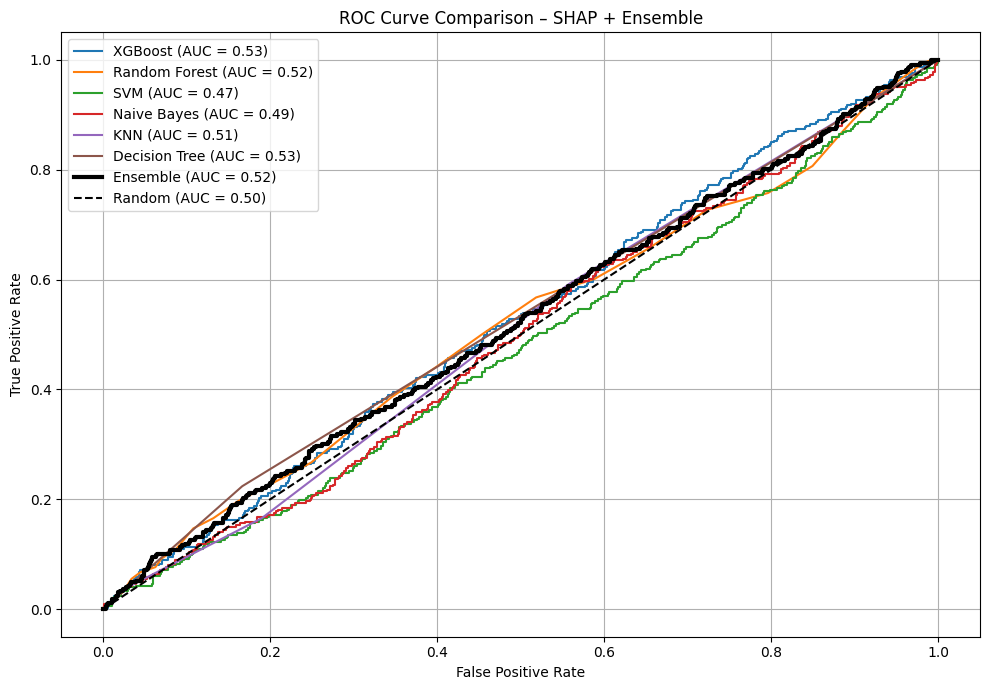

✅ FINAL ENSEMBLE RESULTS
Accuracy: 83.7 %
F1-Score (High Risk): 0.0 %
Precision (High Risk): 0.0 %
Recall (High Risk): 0.0 %
AUC: 52.03 %


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('/content/synthetic_lung_cancer_dataset.csv')

# Encode categorical features
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])
df['Chronic Respiratory Diseases'] = df['Chronic Respiratory Diseases'].fillna('None')
df['Chronic Respiratory Diseases'] = LabelEncoder().fit_transform(df['Chronic Respiratory Diseases'])
df['Cancer Stage'] = LabelEncoder().fit_transform(df['Cancer Stage'])

# Define features
E_cols = ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'VOCs (ppb)', 'CO (ppm)', 'NO2 (ppm)', 'SO2 (ppm)',
          'Temperature (°C)', 'Humidity (%)', 'Tobacco Smoke Exposure']
B_cols = ['SpO2 (%)', 'Resting Heart Rate (bpm)', 'Respiratory Rate (breaths/min)', 'FeNO (ppb)',
          'Exhaled VOC Biomarkers (ppb)', 'Blood Sugar Level (mg/dL)']
features = df[E_cols + B_cols]
labels = df['Chest X-ray/CT Scan Results']

# Normalize
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Split
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

# SHAP-based feature selection
xgb_base = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_base.fit(X_train, y_train)
explainer = shap.Explainer(xgb_base, X_train)
shap_values = explainer(X_train)
mean_shap = np.abs(shap_values.values).mean(axis=0)
top_indices = np.argsort(mean_shap)[-10:]  # Top 10 features

# Select important features
X_train_sel = X_train[:, top_indices]
X_test_sel = X_test[:, top_indices]

# Train all models on selected features
models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_sel, y_train)
    y_pred = model.predict(X_test_sel)
    y_proba = model.predict_proba(X_test_sel)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = auc(*roc_curve(y_test, y_proba)[:2])
    results[name] = {
        "model": model,
        "accuracy": acc,
        "f1_high": report["1"]["f1-score"],
        "precision_high": report["1"]["precision"],
        "recall_high": report["1"]["recall"],
        "roc_auc": roc_auc,
        "proba": y_proba
    }

# Voting Ensemble
voting_clf = VotingClassifier(estimators=[
    ('xgb', models["XGBoost"]),
    ('rf', models["Random Forest"]),
    ('svm', models["SVM"])
], voting='soft')

voting_clf.fit(X_train_sel, y_train)
y_pred_vote = voting_clf.predict(X_test_sel)
y_proba_vote = voting_clf.predict_proba(X_test_sel)[:, 1]
vote_report = classification_report(y_test, y_pred_vote, output_dict=True)
vote_auc = auc(*roc_curve(y_test, y_proba_vote)[:2])
vote_acc = accuracy_score(y_test, y_pred_vote)

# Plot ROC curves
plt.figure(figsize=(10, 7))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res["proba"])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {res["roc_auc"]:.2f})')

fpr_vote, tpr_vote, _ = roc_curve(y_test, y_proba_vote)
plt.plot(fpr_vote, tpr_vote, label=f'Ensemble (AUC = {vote_auc:.2f})', linewidth=3, color='black')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
plt.title("ROC Curve Comparison – SHAP + Ensemble")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Final Output
print("✅ FINAL ENSEMBLE RESULTS")
print("Accuracy:", round(vote_acc * 100, 2), "%")
print("F1-Score (High Risk):", round(vote_report['1']['f1-score'] * 100, 2), "%")
print("Precision (High Risk):", round(vote_report['1']['precision'] * 100, 2), "%")
print("Recall (High Risk):", round(vote_report['1']['recall'] * 100, 2), "%")
print("AUC:", round(vote_auc * 100, 2), "%")
